The dataset is 1,000,000 rows but a sample size of 10000 is used to save time. However, it is stratified to maintain the same fraud ratio.

In [1]:
import pandas as pd

df = pd.read_csv("../data/card_transdata.csv")
df.drop_duplicates(inplace=True)

# perform stratified sampling
fraud_ratio = df["fraud"].value_counts(normalize=True)
df_sample = df.groupby("fraud", group_keys=False).apply(lambda x: x.sample(frac=10000 / len(df), random_state=42))

# verify the fraud ratio in the sample
original_fraud_ratio = df["fraud"].mean()
sample_fraud_ratio = df_sample["fraud"].mean()

# display the sampled df and verify fraud ratios
print(df_sample.head())
print(fraud_ratio.to_dict())
print(f"Original Fraud Ratio: {original_fraud_ratio:.4f}")
print(f"Sample Fraud Ratio: {sample_fraud_ratio:.4f}")
df = df_sample

        distance_from_home  distance_from_last_transaction  \
763547            8.073065                        0.614990   
23634            31.994433                        5.808574   
157152            8.015637                        4.319242   
238071            6.230256                        0.796154   
846711           44.997072                       10.943190   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
763547                        0.077806              1.0        0.0   
23634                         1.186485              1.0        0.0   
157152                        0.906554              1.0        0.0   
238071                        0.206875              1.0        1.0   
846711                        0.856966              1.0        0.0   

        used_pin_number  online_order  fraud  
763547              0.0           1.0    0.0  
23634               1.0           0.0    0.0  
157152              0.0           1.0    0.0  
238071            

C:\Users\wyman\AppData\Local\Temp\ipykernel_26496\398348881.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("fraud", group_keys=False).apply(lambda x: x.sample(frac=10000 / len(df), random_state=42))


This block inspects the dataset for missing values and general information, such as data types and statistical summaries.

In [2]:
# check for missing values
print("Missing values:\n", df.isnull().sum())

# visualize basic statistics
print("Dataset Info:\n")
df.info()
print("\nSummary Statistics:\n")
print(df.describe())

Missing values:
 distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 763547 to 128321
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              10000 non-null  float64
 1   distance_from_last_transaction  10000 non-null  float64
 2   ratio_to_median_purchase_price  10000 non-null  float64
 3   repeat_retailer                 10000 non-null  float64
 4   used_chip                       10000 non-null  float64
 5   used_pin_number                 10000 non-null  float64
 6   online_order                    10000 non-null  float64
 7   frau

This block normalizes the numeric features using StandardScaler to ensure that the Random Forest algorithm performs effectively. StandardScaler normalizes the data such that the Mean equals 0 and the Standard Deviation equals 1. The binary columns are left unchanged.

In [3]:
from sklearn.preprocessing import StandardScaler

# separate features and labels
X = df.drop(columns=['fraud'], axis=1)  
y = df['fraud'] 

# separate binary columns
binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]

# separate continuous columns
continuous_columns = [col for col in X.columns if col not in binary_columns]

# scale only the continuous columns
scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

# combine binary and scaled continuous data
X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

# check that the classification labels were split properly
print("\nValue Counts for Target Labels:")
print(y.value_counts())
print(f"Fraud ratio: {y.mean()}")

# check that the other features were properly scaled
X_scaled.head()


Value Counts for Target Labels:
fraud
0.0    9126
1.0     874
Name: count, dtype: int64
Fraud ratio: 0.0874


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,-0.300468,-0.171813,-0.620199,1.0,0.0,0.0,1.0
1,0.069724,0.029595,-0.233014,1.0,0.0,1.0,0.0
2,-0.301357,-0.028162,-0.330774,1.0,0.0,0.0,1.0
3,-0.328986,-0.164787,-0.575124,1.0,1.0,0.0,0.0
4,0.270945,0.228716,-0.348092,1.0,0.0,0.0,1.0


PCA is run with various combinations of retained variance thresholds and hyperparameters to determine the optimal set of parameters for Random Forest with a PCA approach based primarily on the accuracy, which measures the proportion of correct predictions (both positive and negative) the model makes out of all predictions. The best combination of parameters is maintained for later testing.

PCA Threshold: 0.7, n_estimators: 50, max_depth: None, Mean Accuracy: 0.9270, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9279, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9284, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 100, max_depth: None, Mean Accuracy: 0.9265, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9293, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9275, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 150, max_depth: None, Mean Accuracy: 0.9254, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9289, Retained Components: 3, Removed Components: 4
PCA Threshold

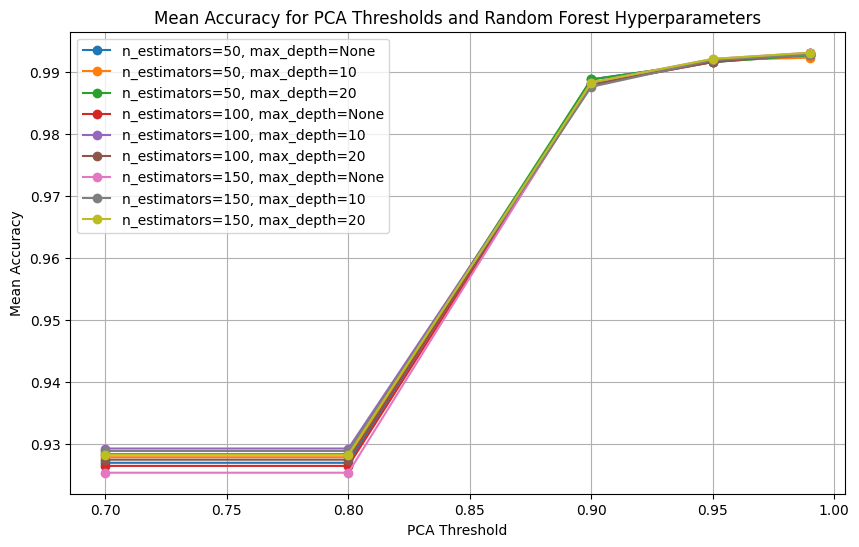

In [4]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# define PCA thresholds and cluster range
pca_thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]

# define hyperparameters for random forest
n_estimators_range = [50, 100, 150]
max_depth_range = [None, 10, 20]

# to store (pca_threshold, n_estimators, max_depth, mean_accuracy)
pca_results = []  

original_components = X_scaled.shape[1]

for pca_threshold in pca_thresholds:
    # apply PCA with the current threshold
    pca = PCA(n_components=pca_threshold)
    X_pca = pca.fit_transform(X_scaled)

    # count retained and removed components
    retained_components = pca.n_components_
    removed_components = original_components - retained_components

    # iterate over hyperparameter combinations
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            # train random forest with this combination of parameters
            rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            # use cross-validation to get accuracy
            accuracies = cross_val_score(rf, X_pca, y, cv=5, scoring='accuracy')
            mean_accuracy = np.mean(accuracies)
            pca_results.append((pca_threshold, n_estimators, max_depth, mean_accuracy))
            # print metrics
            print(
                f"PCA Threshold: {pca_threshold}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
                f"Mean Accuracy: {mean_accuracy:.4f}, "
                f"Retained Components: {retained_components}, Removed Components: {removed_components}"
            )

# find the best combination of  (pca_threshold, n_estimators, max_depth, mean_accuracy)
best_pca_threshold, best_n_estimators_pca, best_max_depth_pca, best_accuracy_pca = max(pca_results, key=lambda x: x[3])
print(f"\nBest PCA Threshold: {best_pca_threshold}, Best n_estimators: {best_n_estimators_pca}, Best max_depth: {best_max_depth_pca}, Best Mean Accuracy: {best_accuracy_pca:.4f}")

# visualize silhouette scores
results_array = np.array(pca_results, dtype=object)

plt.figure(figsize=(10, 6))
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        indices = (results_array[:, 1] == n_estimators) & (results_array[:, 2] == max_depth)
        thresholds = results_array[indices][:, 0]
        accuracies = results_array[indices][:, 3].astype(float)
        plt.plot(thresholds, accuracies, marker='o', label=f'n_estimators={n_estimators}, max_depth={max_depth}')

plt.title("Mean Accuracy for PCA Thresholds and Random Forest Hyperparameters")
plt.xlabel("PCA Threshold")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.grid()
plt.show()

The number of estimators or depth did not seem to have a real effect on the mean accuracy compared to increasing the PCA threshold. The base accuracy is already high so applying the model to the PCA reduced dataset seems very well-suited for this problem. 

t-SNE is run with various combinations of perplexities and hyperparameters to determine the optimal set of parameters for Random Forest with a t-SNE approach based primarily on the silhouette score and the ARI. The trustworthiness is useful to verify that the local structure of the data is properly reflected after the dimension reduction, which is important for visualization, but the other metrics better measure how well the data is preservered after being reduced. t-SNE seems to prefer a higher amount of n-estimators and a lower perplexity. The higher estimators could be because that in the reduced feature space, each tree in the forest has less information to make a split, and the lower perplexity could  be because t-SNE works better at preserving local structures in data and higher perplexity introduces more noise.

t-SNE Perplexity: 5, n_estimators: 50, max_depth: None, Mean Accuracy: 0.9890, Mean F1 Score: 0.9649, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9877, Mean F1 Score: 0.9605, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9890, Mean F1 Score: 0.9649, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 100, max_depth: None, Mean Accuracy: 0.9885, Mean F1 Score: 0.9633, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9881, Mean F1 Score: 0.9618, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9885, Mean F1 Score: 0.9633, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 150, max_depth: None, Mean Accuracy: 0.9887, Mean F1 Score: 0.9640, Trustworthiness: 0.9997
t-SNE Perplexity: 5, n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9881, Mean F1 Score: 0.9618, Trustworthiness: 0.99

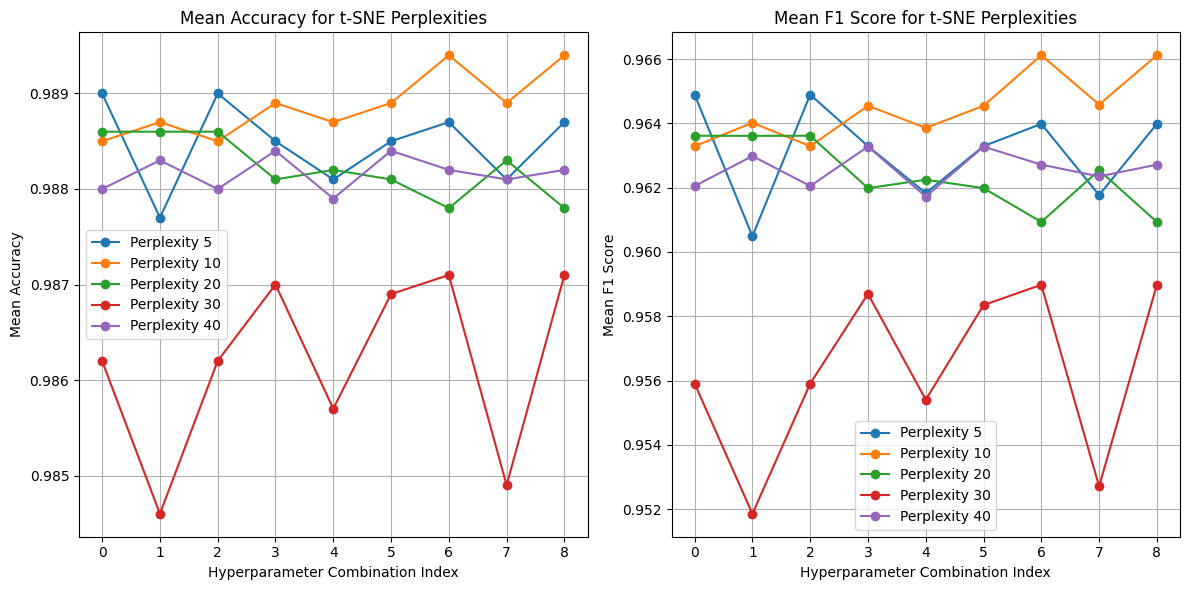

In [5]:
from sklearn.manifold import TSNE, trustworthiness
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np

# define t-SNE perplexity values
tsne_perplexities = [5, 10, 20, 30, 40]

# define random forest hyperparameters
n_estimators_range = [50, 100, 150]
max_depth_range = [None, 10, 20]

# to store (best_tsne_perplexity, best_n_estimators_tsne, best_max_depth_tsne,
#  best_accuracy_tsne, best_f1_tsne, best_trustworthiness_tsne)
tsne_results = []  

# iterate over t-SNE perplexities
for perplexity in tsne_perplexities:

    # apply t-SNE with the current perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)

    # calculate trustworthiness for this t-SNE
    trust = trustworthiness(X_scaled, X_tsne, n_neighbors=5)

    # iterate over random forest hyperparameter combinations
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            # train random forest with cross-validation
            rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
            cv_results = cross_validate(rf, X_tsne, y, cv=5, scoring=scoring)
            mean_accuracy = np.mean(cv_results['test_accuracy'])
            mean_f1 = np.mean(cv_results['test_f1_macro'])
            tsne_results.append((perplexity, n_estimators, max_depth, mean_accuracy, mean_f1, trust))
            # print details
            print(
                f"t-SNE Perplexity: {perplexity}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
                f"Mean Accuracy: {mean_accuracy:.4f}, Mean F1 Score: {mean_f1:.4f}, Trustworthiness: {trust:.4f}"
            )

# find the best combination based on mean F1 score
best_tsne_trial = max(tsne_results, key=lambda x: x[4])  # Maximize mean_f1
best_tsne_perplexity, best_n_estimators_tsne, best_max_depth_tsne, best_accuracy_tsne, best_f1_tsne, best_trustworthiness_tsne = best_tsne_trial

# print the optimal parameters
print(f"\nBest t-SNE Perplexity: {best_tsne_perplexity}, Best n_estimators: {best_n_estimators_tsne}, Best max_depth: {best_max_depth_tsne}")
print(f"Best Mean Accuracy: {best_accuracy_tsne:.4f}, Best Mean F1 Score: {best_f1_tsne:.4f}, Best Trustworthiness: {best_trustworthiness_tsne:.4f}")

# visualize mean accuracy and mean f1 Score for t-SNE
results_array_tsne = np.array(tsne_results, dtype=object)
plt.figure(figsize=(12, 6))

# plot the mean accuracy
plt.subplot(1, 2, 1)
for i, perplexity in enumerate(tsne_perplexities):
    indices = results_array_tsne[:, 0] == perplexity
    mean_accuracies = results_array_tsne[indices][:, 3].astype(float)
    label = f'Perplexity {perplexity}'
    plt.plot(range(len(mean_accuracies)), mean_accuracies, marker='o', label=label)

plt.title("Mean Accuracy for t-SNE Perplexities")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.grid()

# plot the mean f1 score
plt.subplot(1, 2, 2)
for i, perplexity in enumerate(tsne_perplexities):
    indices = results_array_tsne[:, 0] == perplexity
    mean_f1_scores = results_array_tsne[indices][:, 4].astype(float)
    label = f'Perplexity {perplexity}'
    plt.plot(range(len(mean_f1_scores)), mean_f1_scores, marker='o', label=label)

plt.title("Mean F1 Score for t-SNE Perplexities")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Mean F1 Score")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

This block runs cross validation with and without smote on the dataset using either PCA, t-SNE, or no dimension reduction and compares the metrics of the outcomes. Then graphs are generated that show the impact of SMOTE on the training.

Running with no dimensionality reduction...
No dimensionality reduction...
Before SMOTE: X_train size = 10000, y_train size = 10000
After SMOTE: X_train_smote size = 18252, y_train_smote size = 18252

Running Cross-Validation (No Dimensionality Reduction)...
Fold 1/5
SMOTE - Accuracy: 0.9995, Precision: 1.0000, Recall: 0.9943, F1-Score: 0.9971
No SMOTE - Accuracy: 0.9995, Precision: 1.0000, Recall: 0.9943, F1-Score: 0.9971
Fold 2/5
SMOTE - Accuracy: 0.9975, Precision: 1.0000, Recall: 0.9714, F1-Score: 0.9855
No SMOTE - Accuracy: 0.9975, Precision: 1.0000, Recall: 0.9714, F1-Score: 0.9855
Fold 3/5
SMOTE - Accuracy: 0.9980, Precision: 1.0000, Recall: 0.9771, F1-Score: 0.9884
No SMOTE - Accuracy: 0.9975, Precision: 1.0000, Recall: 0.9714, F1-Score: 0.9855
Fold 4/5
SMOTE - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
No SMOTE - Accuracy: 0.9995, Precision: 1.0000, Recall: 0.9943, F1-Score: 0.9971
Fold 5/5
SMOTE - Accuracy: 0.9985, Precision: 1.0000, Recall: 0.9829,

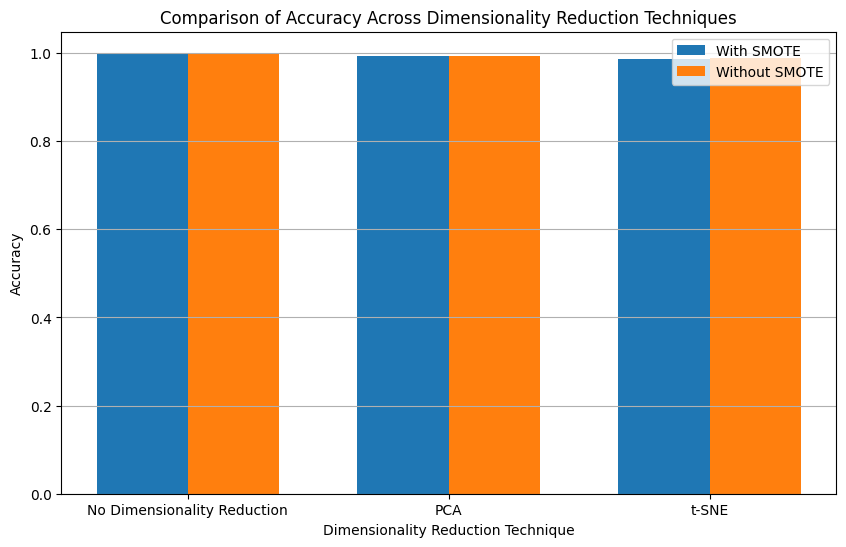

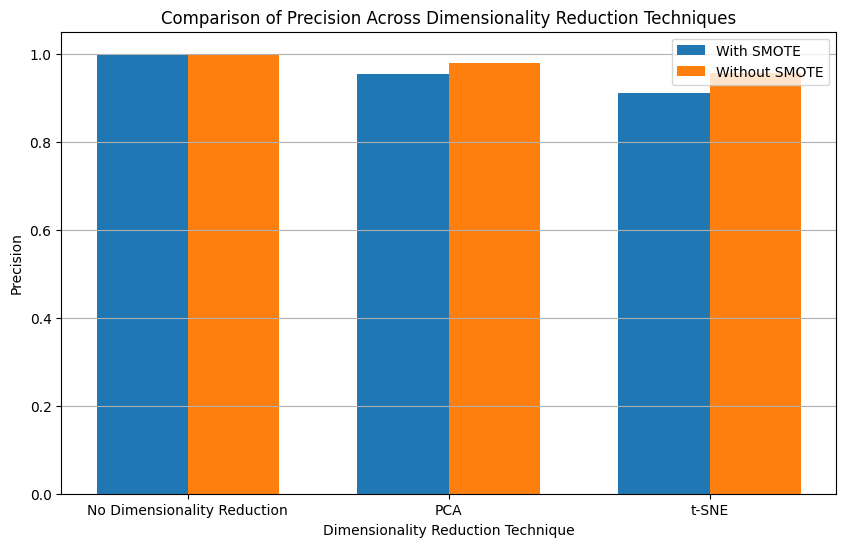

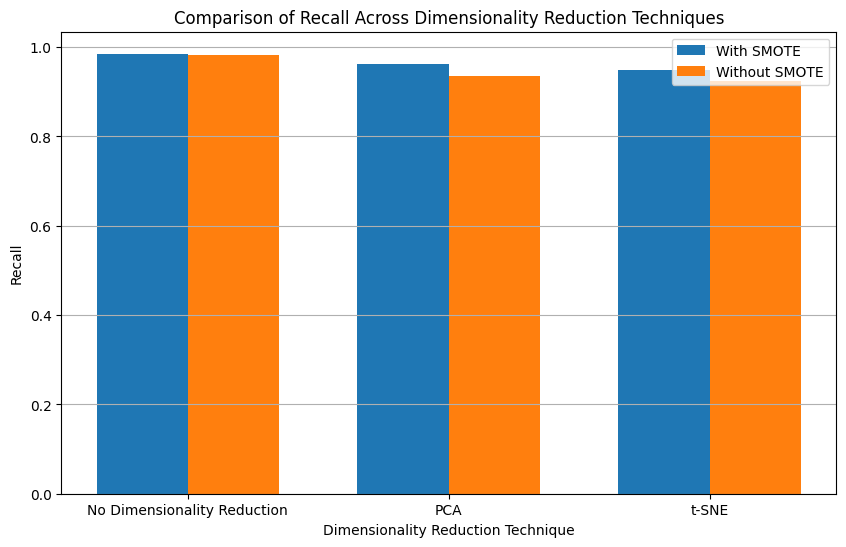

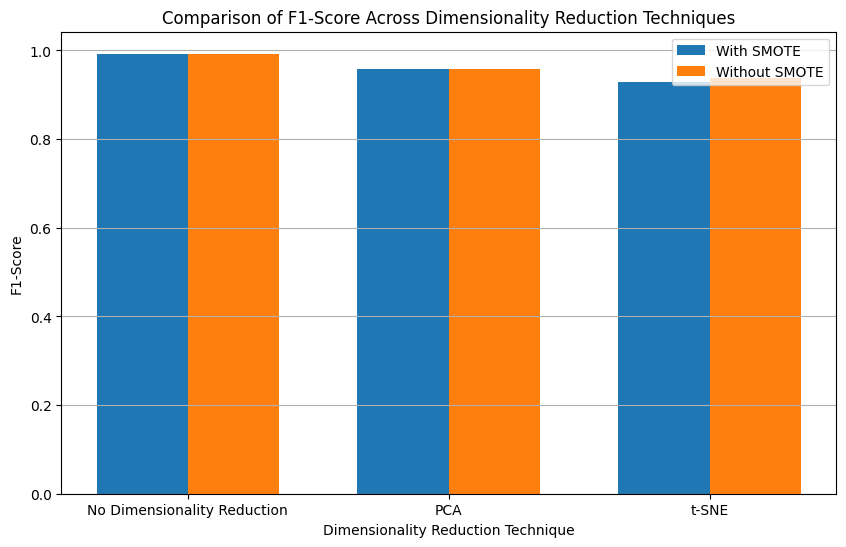

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

def run_dimensionality_reduction_and_cv(X, y, method=None, n_splits=5,
                                        n_estimators=100, max_depth=None,
                                        pca_threshold=None, tsne_perplexity=None):
    """
    Args:
    - X: Feature matrix
    - y: Target labels
    - method: 'PCA', 'TSNE', or None for no dimensionality reduction
    - n_splits: Number of splits for Stratified K-Fold
    - n_estimators: Number of trees in Random Forest
    - max_depth: Max depth of the trees in Random Forest
    - pca_threshold: Variance threshold for PCA
    - tsne_perplexity: Perplexity parameter for t-SNE

    Returns:
    - Metrics for both SMOTE and non-SMOTE runs
    """
    # run the model with the corresponding dimension reduction technique with the optimal parameters found earlier
    if method == "PCA":
        print("Applying PCA...")
        reducer = PCA(n_components=pca_threshold)
        X_reduced = reducer.fit_transform(X)
    elif method == "TSNE":
        print("Applying t-SNE...")
        reducer = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=42, learning_rate=200)
        X_reduced = reducer.fit_transform(X)
    elif method is None:
        print("No dimensionality reduction...")
        X_reduced = X
    else:
        raise ValueError("Method must be 'PCA', 'TSNE', or None")
    
    # ensure X_reduced and y are NumPy array
    X_reduced = np.array(X_reduced)
    y_np = np.array(y)  

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # calculate SMOTE sizes before folds begin
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_reduced, y)
    print(f"Before SMOTE: X_train size = {X_reduced.shape[0]}, y_train size = {len(y)}")
    print(f"After SMOTE: X_train_smote size = {X_train_smote.shape[0]}, y_train_smote size = {y_train_smote.shape[0]}")

    fold_results_smote = []
    fold_results_no_smote = []

    # cross-validation loop
    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"Fold {fold + 1}/{n_splits}")

        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        # cross-validation WITH SMOTE
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        rf_smote = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_smote.fit(X_train_smote, y_train_smote)
        y_pred_smote = rf_smote.predict(X_val)

        # evaluate metrics for SMOTE
        accuracy_smote = accuracy_score(y_val, y_pred_smote)
        precision_smote = precision_score(y_val, y_pred_smote, pos_label=1, zero_division=0)
        recall_smote = recall_score(y_val, y_pred_smote, pos_label=1, zero_division=0)
        f1_smote = f1_score(y_val, y_pred_smote, pos_label=1, zero_division=0)
        fold_results_smote.append((accuracy_smote, precision_smote, recall_smote, f1_smote))
        print(f"SMOTE - Accuracy: {accuracy_smote:.4f}, Precision: {precision_smote:.4f}, Recall: {recall_smote:.4f}, F1-Score: {f1_smote:.4f}")

        # cross-validation WITHOUT SMOTE
        rf_no_smote = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_no_smote.fit(X_train, y_train)
        y_pred_no_smote = rf_no_smote.predict(X_val)

        # evaluate metrics for non-SMOTE
        accuracy_no_smote = accuracy_score(y_val, y_pred_no_smote)
        precision_no_smote = precision_score(y_val, y_pred_no_smote, pos_label=1, zero_division=0)
        recall_no_smote = recall_score(y_val, y_pred_no_smote, pos_label=1, zero_division=0)
        f1_no_smote = f1_score(y_val, y_pred_no_smote, pos_label=1, zero_division=0)
        fold_results_no_smote.append((accuracy_no_smote, precision_no_smote, recall_no_smote, f1_no_smote))
        
        print(f"No SMOTE - Accuracy: {accuracy_no_smote:.4f}, Precision: {precision_no_smote:.4f}, Recall: {recall_no_smote:.4f}, F1-Score: {f1_no_smote:.4f}")
    
    # aggregate metrics
    avg_metrics_smote = np.mean(fold_results_smote, axis=0)
    avg_metrics_no_smote = np.mean(fold_results_no_smote, axis=0)
    print(f"\nAverage Metrics Across Folds WITH SMOTE: Accuracy: {avg_metrics_smote[0]:.4f}, Precision: {avg_metrics_smote[1]:.4f}, Recall: {avg_metrics_smote[2]:.4f}, F1-Score: {avg_metrics_smote[3]:.4f}")
    print(f"Average Metrics Across Folds WITHOUT SMOTE: Accuracy: {avg_metrics_no_smote[0]:.4f}, Precision: {avg_metrics_no_smote[1]:.4f}, Recall: {avg_metrics_no_smote[2]:.4f}, F1-Score: {avg_metrics_no_smote[3]:.4f}")

    return avg_metrics_smote, avg_metrics_no_smote

best_n_estimators_no_reduction = 100
best_max_depth_no_reduction = None

# run for no dimensionality reduction
print("Running with no dimensionality reduction...")
metrics_no_reduction_smote, metrics_no_reduction_no_smote = run_dimensionality_reduction_and_cv(
    X_scaled, y, method=None, n_estimators=best_n_estimators_no_reduction, max_depth=best_max_depth_no_reduction)

# run for PCA
print("\nRunning PCA...")
metrics_pca_smote, metrics_pca_no_smote = run_dimensionality_reduction_and_cv(
    X_scaled, y, method="PCA", n_estimators=best_n_estimators_pca, max_depth=best_max_depth_pca, pca_threshold=best_pca_threshold)

# run for t-SNE
print("\nRunning t-SNE...")
metrics_tsne_smote, metrics_tsne_no_smote = run_dimensionality_reduction_and_cv(
    X_scaled, y, method="TSNE", n_estimators=best_n_estimators_tsne, max_depth=best_max_depth_tsne, tsne_perplexity=best_tsne_perplexity)

# collect metrics for plotting
methods = ["No Dimensionality Reduction", "PCA", "t-SNE"]
metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]

# create lists to store metrics
smote_metrics_list = [metrics_no_reduction_smote, metrics_pca_smote, metrics_tsne_smote]
no_smote_metrics_list = [metrics_no_reduction_no_smote, metrics_pca_no_smote, metrics_tsne_no_smote]

# convert lists to NumPy arrays
scores_smote = np.array(smote_metrics_list)
scores_no_smote = np.array(no_smote_metrics_list)

# plot the comparisons with adjacent bars
x = np.arange(len(methods))
width = 0.35 

# loop through all the metrics and create each graph, comparing the scores with and without SMOTE
for i, metric_label in enumerate(metrics_labels):
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, scores_smote[:, i], width, label="With SMOTE")
    plt.bar(x + width/2, scores_no_smote[:, i], width, label="Without SMOTE")
    
    plt.title(f"Comparison of {metric_label} Across Dimensionality Reduction Techniques")
    plt.ylabel(metric_label)
    plt.xlabel("Dimensionality Reduction Technique")
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

The introduction of SMOTE made almost no difference with any of the dimension reduction techniques. Even though the positive case is severely underrepresented, the model still trains on it well. SMOTE  will not be used on the data going forward as I don't think it contributes positively.

The following block evaluates the test set after it has been trained on models using data altered by either PCA, t-SNE, or no dimension reduction.

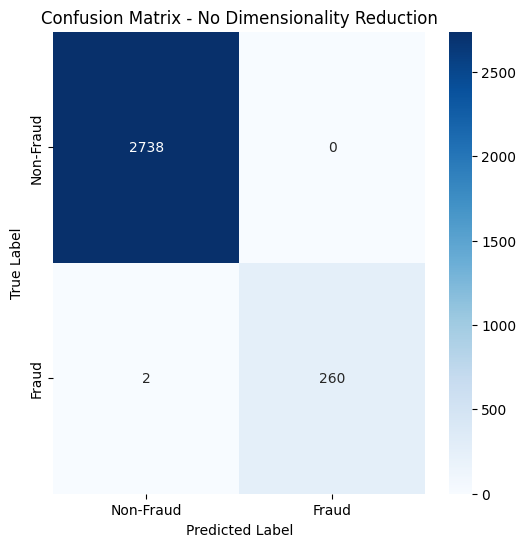

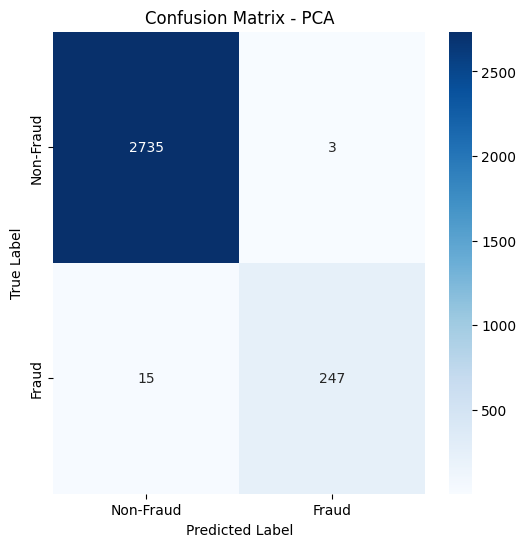

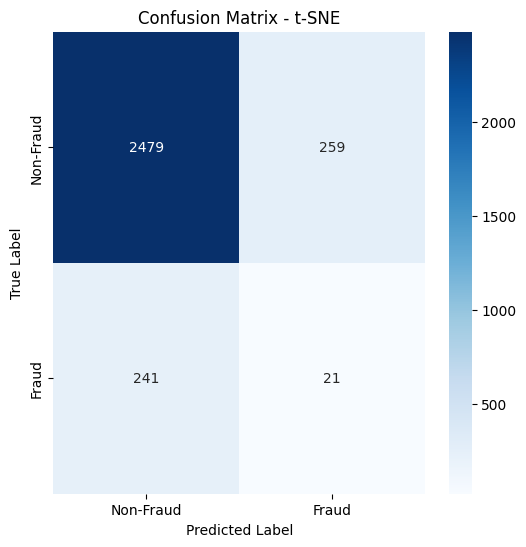

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# function that evaluates a testing function based on a given dimensional reduction method
def evaluate_on_test_set(X_train, y_train, X_test, y_test, method=None,
                         n_estimators=100, max_depth=None,
                         pca_threshold=None, tsne_perplexity=None):
    if method == "PCA":
        reducer = PCA(n_components=best_pca_threshold)
        X_train = reducer.fit_transform(X_train)
        X_test = reducer.transform(X_test)
    elif method == "t-SNE":
        reducer = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=42, learning_rate=200)
        X_train = reducer.fit_transform(X_train)
        X_test = reducer.fit_transform(X_test) 
    elif method is None:
        pass
    else:
        raise ValueError("Invalid dimensionality reduction method")
    
    # train random forest with best hyperparameters
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)

    # predict the test set
    y_pred = rf.predict(X_test)

    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return cm, X_test, y_pred, rf

# evaluate test sets and store results
methods = ["No Dimensionality Reduction", "PCA", "t-SNE"]
test_conf_matrices = {}
reduced_test_sets = {}
test_predictions = {}

# test each method on the test split
for method in methods:
    if method == "No Dimensionality Reduction":
        # use the best hyperparameters found earlier to run RF on data with no dimensionality reduction
        n_estimators = best_n_estimators_no_reduction
        max_depth = best_max_depth_no_reduction
        cm, _, y_pred, rf_model = evaluate_on_test_set(
            X_train, y_train, X_test, y_test, method=None,
            n_estimators=n_estimators, max_depth=max_depth
        )
        # store the trained model
        feature_importance_model = rf_model
    elif method == "PCA":
        # use the best hyperparameters found earlier to run RF on data with PCA dimensionality reduction
        cm, X_test_reduced, y_pred, rf_model = evaluate_on_test_set(
            X_train, y_train, X_test, y_test, method="PCA",
            n_estimators=best_n_estimators_pca, max_depth=best_max_depth_pca,
            pca_threshold=best_pca_threshold
        )
        reduced_test_sets[method] = X_test_reduced
    elif method == "t-SNE":
        # use the best hyperparameters found earlier to run RF on data with t-SNE dimensionality reduction
        cm, X_test_reduced, y_pred, rf_model = evaluate_on_test_set(
            X_train, y_train, X_test, y_test, method="t-SNE",
            n_estimators=best_n_estimators_tsne, max_depth=best_max_depth_tsne,
            tsne_perplexity=best_tsne_perplexity
        )
        reduced_test_sets[method] = X_test_reduced
    test_conf_matrices[method] = cm  # store confusion matrices
    test_predictions[method] = y_pred

# generate heatmaps for the confusion matrices
for method, cm in test_conf_matrices.items():
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {method}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

PCA did not offer much change from no dimensionality reduction. Both of these training methods were very reliable and had high rates of true positives and true negatives. Dimension reduction with t-SNE offered a substantial decrease in performance. t-SNE is more focused on data visualization rather than improving the rate of classification. One problem with t-SNE is that it always reduces to 2 dimensions which could lead to a large loss of relevent information and a less accurate model. 

The following block shows the importance of each feature in relation to predicting a fraud case

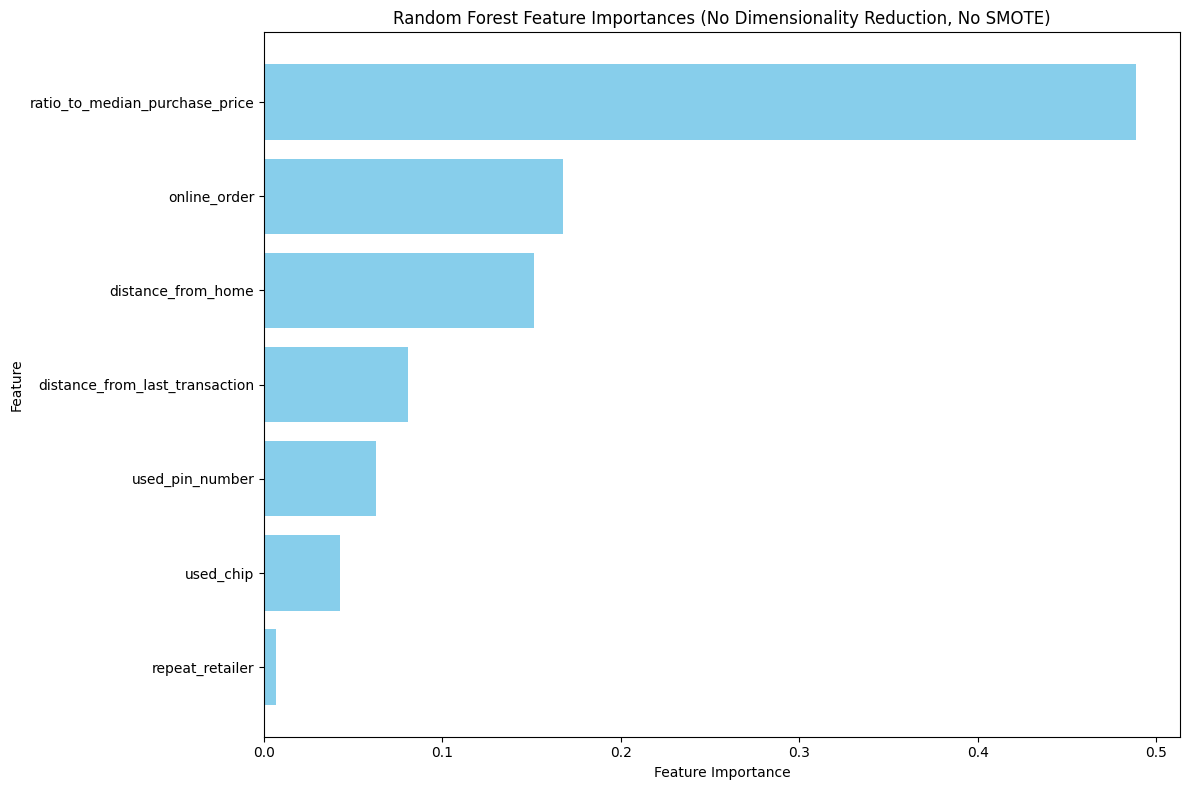

In [9]:
# extract non-target feature names 
feature_names = df.columns.tolist()
feature_names.remove('fraud') 

# used the trained model from the No Dimensionality Reduction trial
rf_no_reduction = feature_importance_model

# calculate feature importances from the trained model
importances = rf_no_reduction.feature_importances_

# create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sort the features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(
    feature_importances_df['Feature'],
    feature_importances_df['Importance'],
    color='skyblue'
)
plt.gca().invert_yaxis()  # most important feature at the top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances (No Dimensionality Reduction, No SMOTE)')
plt.tight_layout()
plt.show()

According to this model, some features are much more important than others. The ratio_to_median_purchase_price, distance_from_home, and online_order seem to be the highest indicators of fraud.